In [27]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split


In [28]:
raw_df = pd.read_csv("data/Country-data.csv")
raw_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [29]:
df=raw_df.copy()
for col in raw_df.columns:
    if col in ['country']: continue
    temp=raw_df[col]#.dropna()
    a=temp.quantile(0.99)-temp.quantile(0.01)
    if a<0.001: a=temp.max()-temp.min()
    df[col] = (df[col]-temp.quantile(0.01))/(temp.quantile(0.99)-temp.quantile(0.01))
# np.round(df.describe([0.01,0.99, 0.5, 0.25, 0.75]),3)

In [30]:
df=raw_df.copy()
for col in raw_df.columns:
    if col in ['country']: continue
    temp=raw_df[col]#.dropna()
    a=temp.std()
    if a==0: a=1
    df[col] = (df[col]-temp.mean())/a
# np.round(df.describe([0.01,0.99, 0.5, 0.25, 0.75]),3)

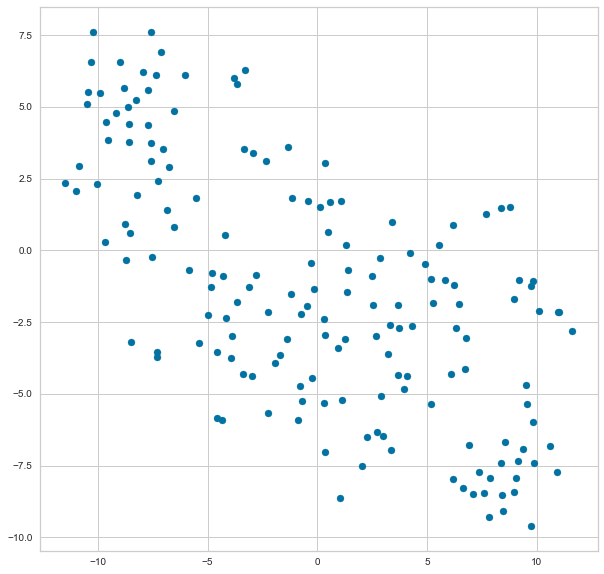

In [31]:
# create tsne plot
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=5000)
tsne_obj = tsne.fit_transform(df.drop('country', axis=1))
#plot tsne
plt.figure(figsize=(10,10))
plt.scatter(tsne_obj[:,0], tsne_obj[:,1])
plt.show()


E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\No1\AppData\Local\Temp\ipykernel_21488\151431831.py:55: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(


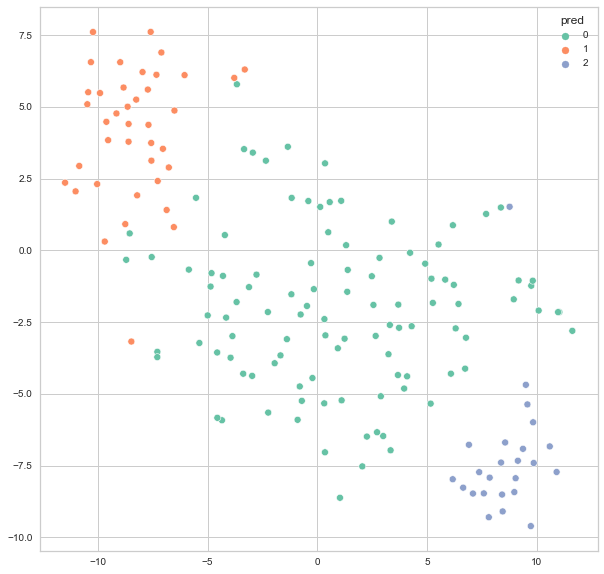

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn

<Figure size 720x720 with 0 Axes>

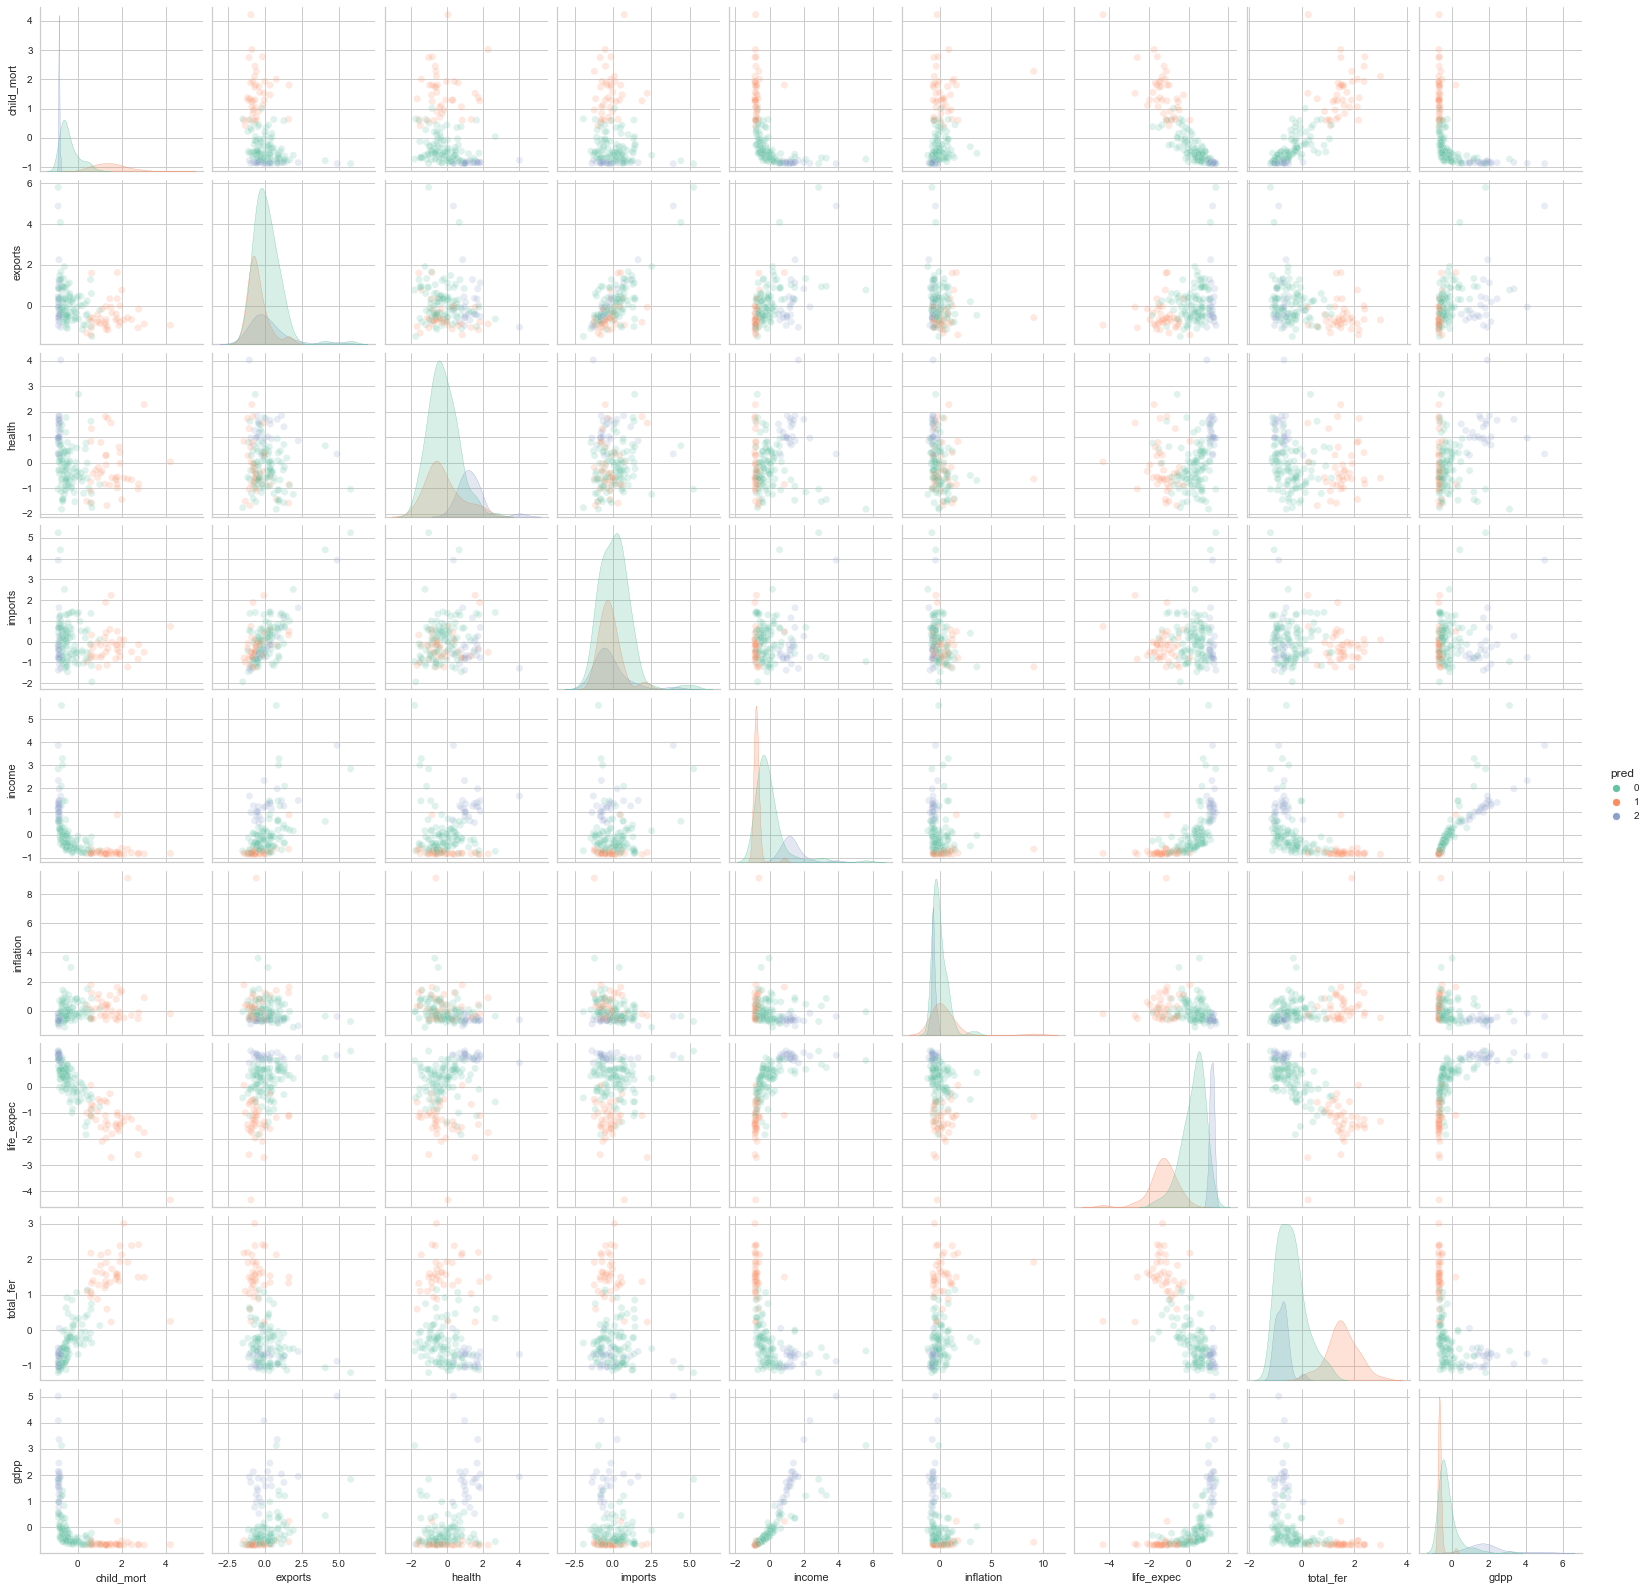

In [44]:
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
class SpectralClustering:
    def __init__(self, n_clusters, gamma=1.0, n_neighbors=10, n_components=2, affinity=0):
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.gamma = gamma
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.eigen_vectors = None
        self.labels = None

    def fit(self, X):
        self.affinity_matrix = [
            kneighbors_graph(X, self.n_neighbors, mode='connectivity', include_self=False),

            radius_neighbors_graph(X, self.n_neighbors, mode='connectivity', include_self=False),
                                ][self.affinity]

        # calculate degree matrix
        self.degree_matrix = np.diag(np.sum(self.affinity_matrix, axis=1))

        # calculate laplacian matrix
        self.laplacian_matrix = self.degree_matrix - self.affinity_matrix

        # calculate eigen values and eigen vectors
        eigen_values, eigen_vectors = np.linalg.eig(self.laplacian_matrix)
        eigen_values = np.real(eigen_values)
        eigen_vectors = np.real(eigen_vectors)

        # sort eigen values and eigen vectors
        idx = eigen_values.argsort()
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]

        # select first n_components eigen vectors
        self.eigen_vectors = eigen_vectors[:, :self.n_components]

        # k-means clustering
        kmeans = KMeans(n_clusters=self.n_clusters)
        kmeans.fit(np.array(self.eigen_vectors))
        self.labels = kmeans.labels_

    def predict(self, X):
        return self.labels

kmeans = SpectralClustering(n_clusters=3)
temp=df.drop('country', axis=1)
kmeans.fit(df.drop('country', axis=1).values)

temp['pred']=kmeans.predict(df.drop('country', axis=1).values)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tsne_obj[:,0], y=tsne_obj[:,1], hue=temp['pred'],
    palette=sns.color_palette("Set2"))
plt.show()

plt.figure(figsize=(10,10))
sns.pairplot(temp, plot_kws={'alpha': 0.2}, hue='pred',
             palette=sns.color_palette("Set2"))
plt.show()

In [42]:
# silhouette for different size
from sklearn.metrics import silhouette_score
for i in range(2,10):
    kmeans = SpectralClustering(n_clusters=i)
    kmeans.fit(df.drop('country', axis=1).values)
    print(i, silhouette_score(df.drop('country', axis=1).values, kmeans.predict(df.drop('country', axis=1).values)))

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

2 0.31822862257379525
3 0.280465793106855
4 0.18770688270378122
5 0.18544243243698244
6 0.17966643988096803
7 0.1955448125284171
8 0.176799479199262
9 0.13970083327364646


E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


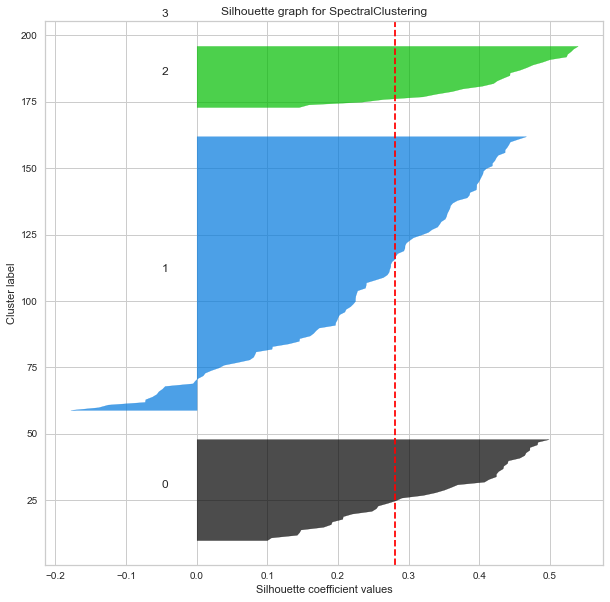

In [34]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# silhouette graph for SpectralClustering
silhouette_avg = silhouette_score(temp.drop('pred', axis=1), temp['pred'])
plt.figure(figsize=(10,10))
plt.title("Silhouette graph for SpectralClustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
silhouette_values = silhouette_samples(temp.drop('pred', axis=1), temp['pred'])
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = silhouette_values[temp['pred'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

C:\Users\No1\AppData\Local\Temp\ipykernel_21488\1381738835.py:9: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(


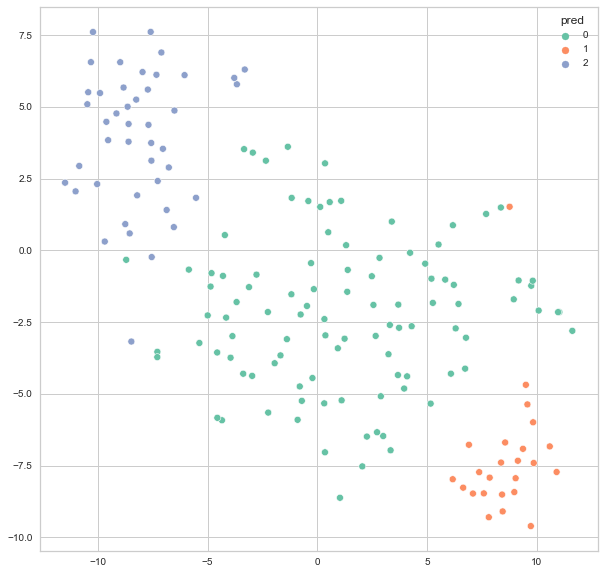

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn

<Figure size 720x720 with 0 Axes>

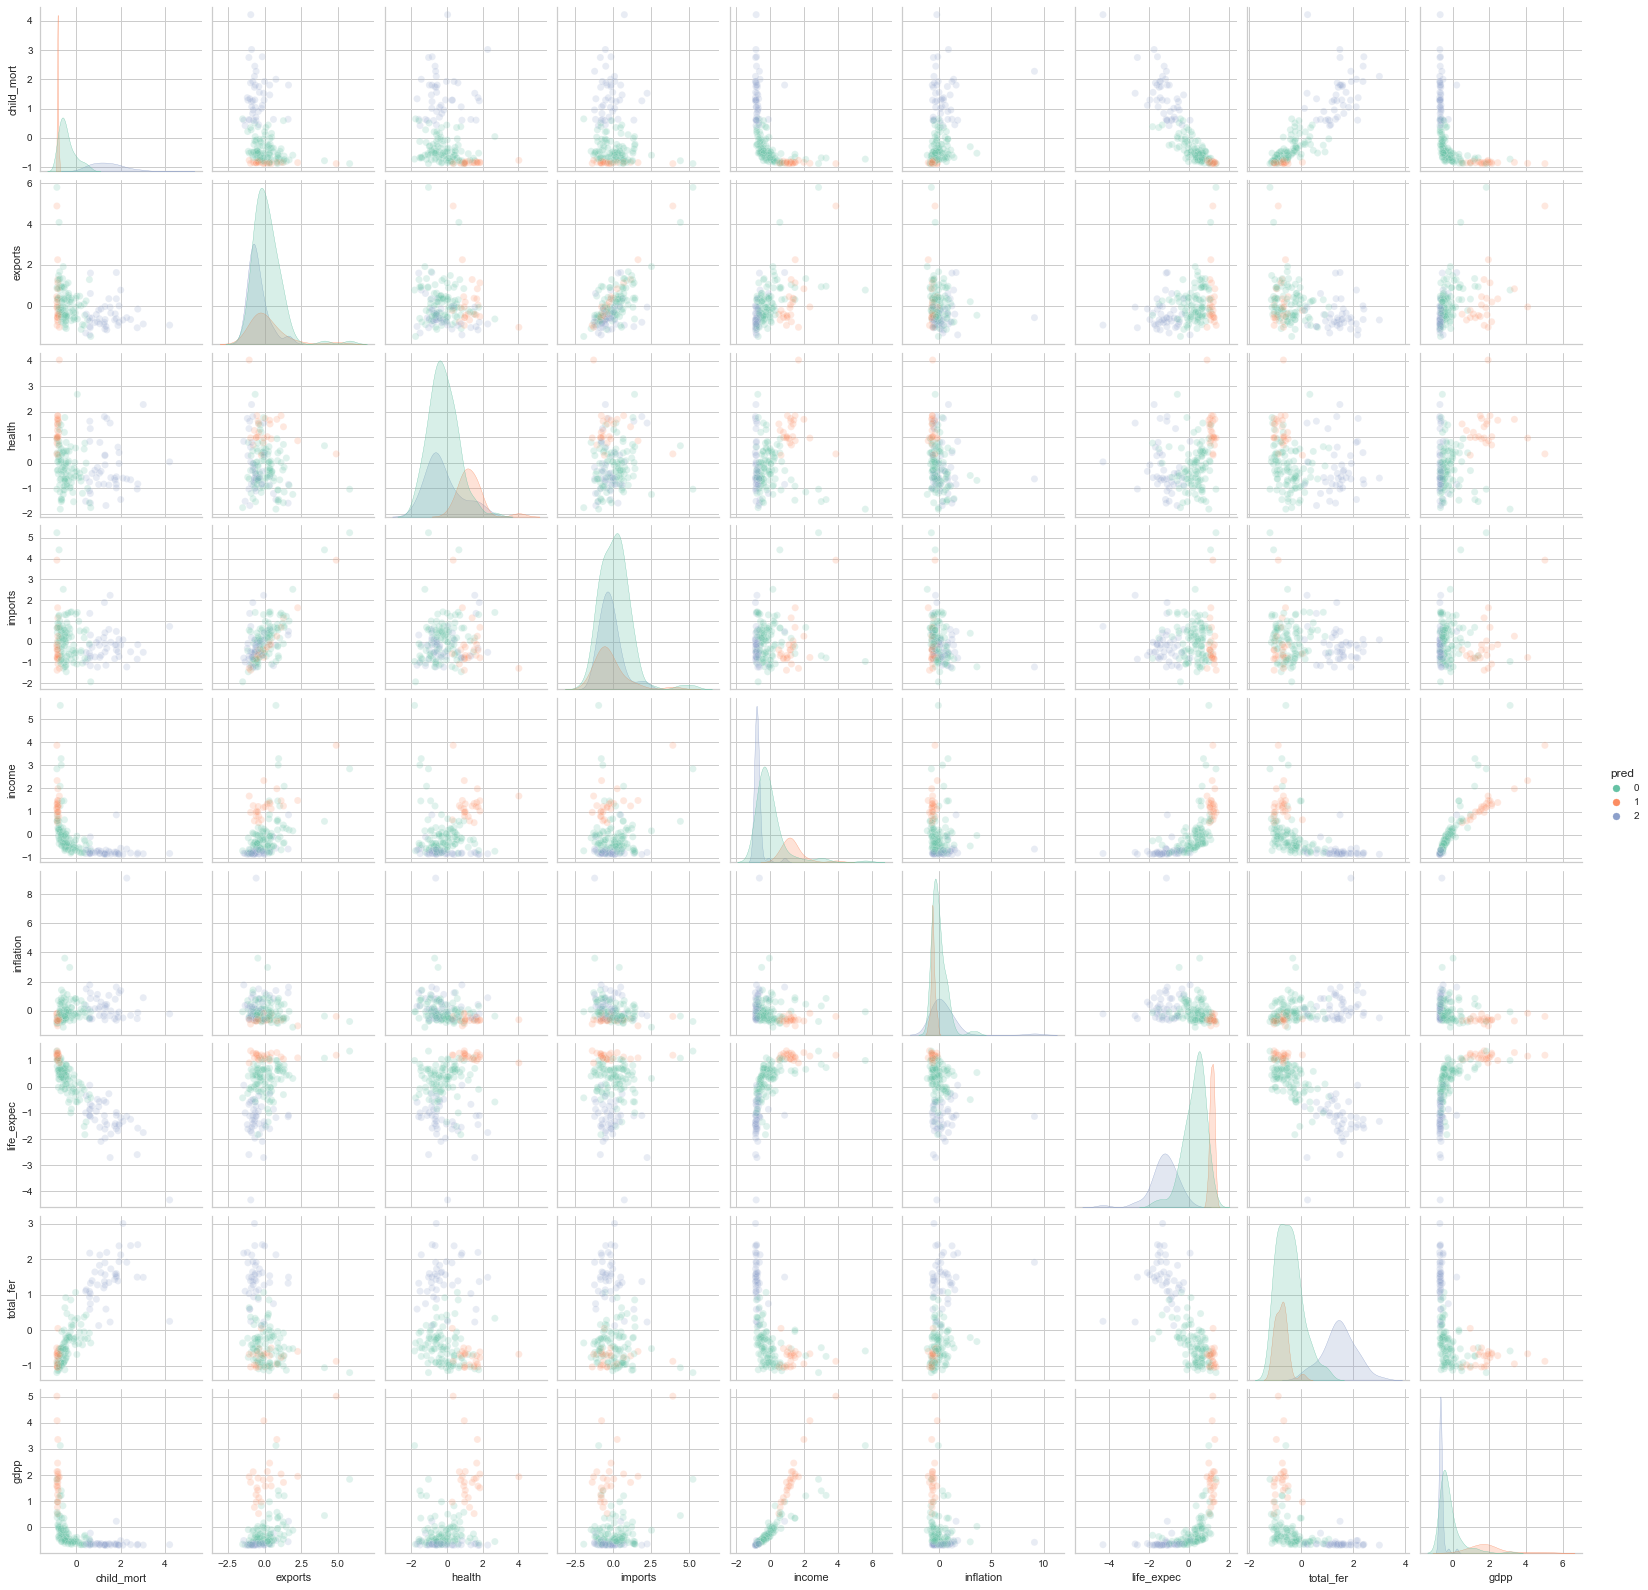

In [35]:
from sklearn.cluster import SpectralClustering
kmeans = SpectralClustering(n_clusters=3, affinity='nearest_neighbors')
temp=df.drop('country', axis=1)
# kmeans.fit(df.drop('country', axis=1).values)

temp['pred']=kmeans.fit_predict(df.drop('country', axis=1).values)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=tsne_obj[:,0], y=tsne_obj[:,1], hue=temp['pred'],
    palette=sns.color_palette("Set2"))
plt.show()

plt.figure(figsize=(10,10))
sns.pairplot(temp, plot_kws={'alpha': 0.2}, hue='pred',
             palette=sns.color_palette("Set2"))
plt.show()

In [43]:
# silhouette for different size
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
for i in range(2,10):
    kmeans = SpectralClustering(n_clusters=i, affinity='nearest_neighbors')
    print(i, silhouette_score(df.drop('country', axis=1).values, kmeans.fit_predict(df.drop('country', axis=1).values)))

2 0.26957682317141984
3 0.2839903775240613
4 0.2032780785696284
5 0.1937885497870621
6 0.1699465174313738
7 0.19317689356204923
8 0.14343488038709773
9 0.12571266957383437


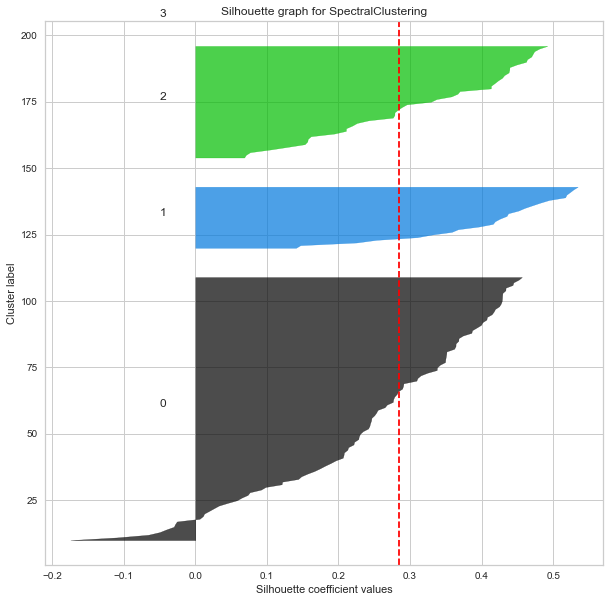

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# silhouette graph for SpectralClustering
silhouette_avg = silhouette_score(temp.drop('pred', axis=1), temp['pred'])
plt.figure(figsize=(10,10))
plt.title("Silhouette graph for SpectralClustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
silhouette_values = silhouette_samples(temp.drop('pred', axis=1), temp['pred'])
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = silhouette_values[temp['pred'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()